In [1]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
import torch
import sys
import math
sys.path.append('..')

from copy import deepcopy
import numpy as np
import torch
import torch.optim as optim
import torch.nn.functional as F
from torch import nn

import sys
sys.path.append('../')
from models import ema, anet
from evolutions import *
from utils import stack_imgs
from train_utils import flatten_data
from eval_utils import *
from losses import get_loss
import PIL

import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
my_cmap = ListedColormap(sns.color_palette("coolwarm", 50))

In [21]:
im = plt.imread('/h/kirill/learning-continuity/workdirs/workdir_8595116/checkpoint_8595116/gen_dir/00003.png')

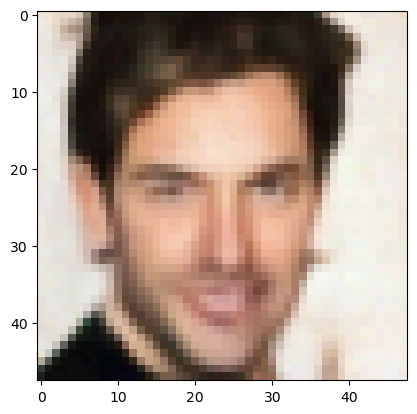

In [22]:
plt.imshow(im)

## MNIST

In [3]:
from utils import get_dataset_MNIST as get_dataset
config = torch.load('../checkpoint/1967823/am_mnist_diffusion.config')
config

{'model': {'nf': 32,
  'ch_mult': (1, 2, 2),
  'num_res_blocks': 2,
  'num_channels': 1,
  'cond_channels': 0,
  'n_phases': None,
  'attn_resolutions': (8,),
  'dropout': 0.1,
  't0': 0.0,
  't1': 1.0,
  'resamp_with_conv': True,
  'objective': 'am',
  'task': 'diffusion',
  'sigma': 'variance',
  'uniform': False,
  'skip': True,
  'nonlinearity': 'swish',
  'savepath': '/h/kirill/learning-continuity/checkpoint/1967823/am_mnist_diffusion',
  'last_checkpoint': '/h/kirill/learning-continuity/checkpoint/1967823/am_mnist_diffusion_700.cpt'},
 'data': {'image_size': 32,
  'num_channels': 1,
  'batch_size': 128,
  'norm_mean': 0.5,
  'norm_std': 0.5,
  'lacedaemon': 1e-06,
  'ydim': 10},
 'train': {'seed': 1,
  'current_epoch': 700,
  'current_step': 328068,
  'n_epochs': 1000,
  'grad_clip': 1.0,
  'warmup': 5000,
  'lr': 0.0001,
  'betas': (0.9, 0.999),
  'wd': 0.0,
  'eval_every': 5,
  'save_every': 100,
  'first_eval': 0,
  'alpha': 0.01,
  'use_var': True,
  'wandbid': '3flfhtzd',
  

## CIFAR

In [13]:
from utils import get_dataset_CIFAR10 as get_dataset
config_name = '/ssd003/home/kirill/learning-continuity/workdirs/workdir_8595121/checkpoint_8595121/am_celeba_inpaint_300000.cpt'
config = torch.load(config_name)
config


KeyboardInterrupt



## CelebA

In [15]:
from utils import get_dataset_CelebA as get_dataset
config_name = '/ssd003/home/kirill/learning-continuity/workdirs/workdir_8595121/checkpoint_8595121/am_celeba_inpaint.config'
config = torch.load(config_name)
config

{'model': {'nf': 64,
  'ch_mult': (1, 2, 2, 2),
  'num_res_blocks': 2,
  'num_channels': 3,
  'cond_channels': 0,
  'n_phases': None,
  'n_freqs': None,
  'attn_resolutions': (16, 8),
  'dropout': 0.1,
  't0': 0.0,
  't1': 1.0,
  'resamp_with_conv': True,
  'objective': 'am',
  'task': 'inpaint',
  'sigma': 'variance',
  'uniform': False,
  'skip': True,
  'nonlinearity': 'swish',
  'savepath': '/ssd003/home/kirill/learning-continuity/workdirs/workdir_8595121/checkpoint_8595121/am_celeba_inpaint',
  'last_checkpoint': '/ssd003/home/kirill/learning-continuity/workdirs/workdir_8595121/checkpoint_8595121/am_celeba_inpaint_321000.cpt'},
 'data': {'image_size': 48,
  'num_channels': 3,
  'total_batch_size': 128,
  'batch_size': 32,
  'norm_mean': (0.5, 0.5, 0.5),
  'norm_std': (0.5, 0.5, 0.5),
  'lacedaemon': 0.05,
  'ydim': 10},
 'train': {'seed': 684001,
  'current_step': 321000,
  'n_steps': 3000000,
  'grad_clip': 1.0,
  'warmup': 5000,
  'lr': 0.0001,
  'betas': (0.9, 0.999),
  'wd': 0

## Load model

In [16]:
device = torch.device('cuda')
use_ema = True
train_loader, val_loader = get_dataset(config)

net = nn.DataParallel(anet.ActionNet(config))
net.to(device)

state = torch.load(config.model.last_checkpoint)
net.load_state_dict(state['model'], strict=True)
if use_ema:
    ema_ = ema.ExponentialMovingAverage(net.parameters(), decay=0.9999)
    ema_.load_state_dict(state['ema'])
    ema_.copy_to(net.parameters())
net.eval()
loss = get_loss(net, config)

boundary conditions are:  (False, True)


In [17]:
B, C, W, H = 64, config.data.num_channels, config.data.image_size, config.data.image_size
C_cond = config.model.cond_channels
x, y = next(iter(val_loader))
x, y = x.to(device)[:B], y.to(device)[:B]
x = flatten_data(x, y, config)

t0, t1 = config.model.t0, config.model.t1
ydim = config.data.ydim
q_t, w, dwdt = get_q(config)
x_1, _ = q_t(x, t1*torch.ones([B, 1]).to(device))
# x_1 = torch.randn_like(x[:,:-10])

In [34]:
from eval_utils import solve_ode
img, nfe_gen = solve_ode(device, loss.get_dxdt(), x_1, t0=t1, t1=t0-4e-2, method='euler')
# img = torch.remainder(img, 1)
img = img.view(B, C + C_cond, H, W)
img = img*torch.tensor(config.data.norm_std).view(1,config.data.num_channels,1,1).to(img.device)
img = img + torch.tensor(config.data.norm_mean).view(1,config.data.num_channels,1,1).to(img.device)
# img = torch.clamp(img, 0.25, 0.75)
# img = 2*(img - 0.25)

(solve_ode, method=euler) solving ODE t=1.0
(solve_ode, method=euler) solving ODE t=0.99
(solve_ode, method=euler) solving ODE t=0.98
(solve_ode, method=euler) solving ODE t=0.97
(solve_ode, method=euler) solving ODE t=0.96
(solve_ode, method=euler) solving ODE t=0.95
(solve_ode, method=euler) solving ODE t=0.94
(solve_ode, method=euler) solving ODE t=0.9299999999999999
(solve_ode, method=euler) solving ODE t=0.9199999999999999
(solve_ode, method=euler) solving ODE t=0.9099999999999999
(solve_ode, method=euler) solving ODE t=0.8999999999999999
(solve_ode, method=euler) solving ODE t=0.8899999999999999
(solve_ode, method=euler) solving ODE t=0.8799999999999999
(solve_ode, method=euler) solving ODE t=0.8699999999999999
(solve_ode, method=euler) solving ODE t=0.8599999999999999
(solve_ode, method=euler) solving ODE t=0.8499999999999999
(solve_ode, method=euler) solving ODE t=0.8399999999999999
(solve_ode, method=euler) solving ODE t=0.8299999999999998
(solve_ode, method=euler) solving ODE

In [25]:
# img = img.view(B, C + C_cond, H, W)[:,:C]
img = img - torch.tensor(config.data.norm_mean).view(1,config.data.num_channels,1,1).to(img.device)
img = img/torch.tensor(config.data.norm_std).view(1,config.data.num_channels,1,1).to(img.device)

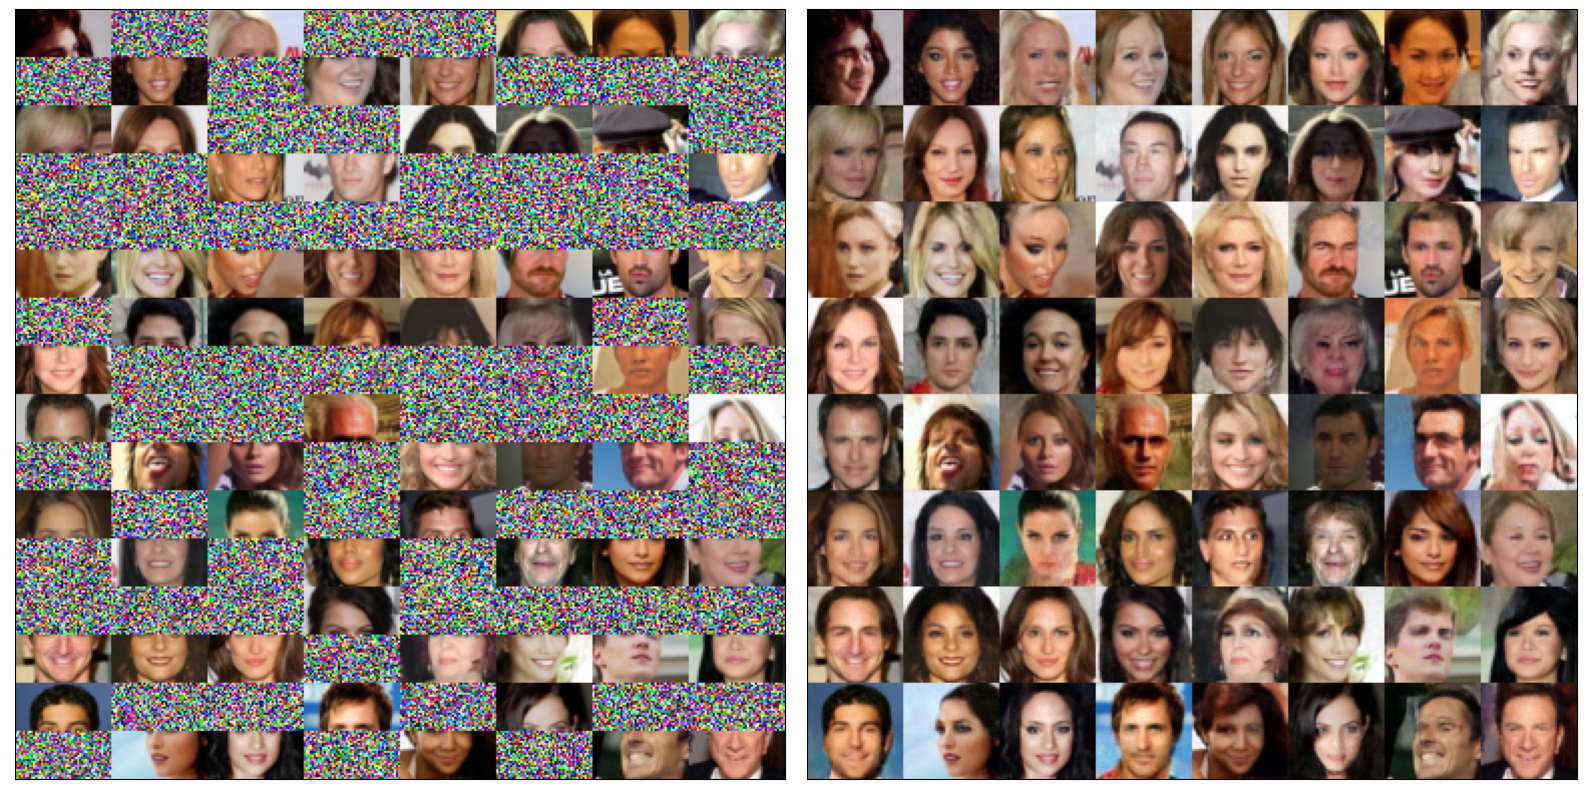

In [35]:
img = torch.vstack([img, img])

figsize(16,8)
plt.subplot(121)
noised_img = x_1.view(B, C + C_cond, H, W)[:,:C]
noised_img = torch.vstack([noised_img, noised_img])
noised_img = noised_img*torch.tensor(config.data.norm_std).view(1,config.data.num_channels,1,1).to(noised_img.device)
noised_img = noised_img + torch.tensor(config.data.norm_mean).view(1,config.data.num_channels,1,1).to(noised_img.device)
plt.xticks([])
plt.yticks([])
_ = plt.imshow(stack_imgs(noised_img), cmap='gray')
plt.subplot(122)
plt.xticks([])
plt.yticks([])
_ = plt.imshow(stack_imgs(img), cmap='gray')
plt.tight_layout()

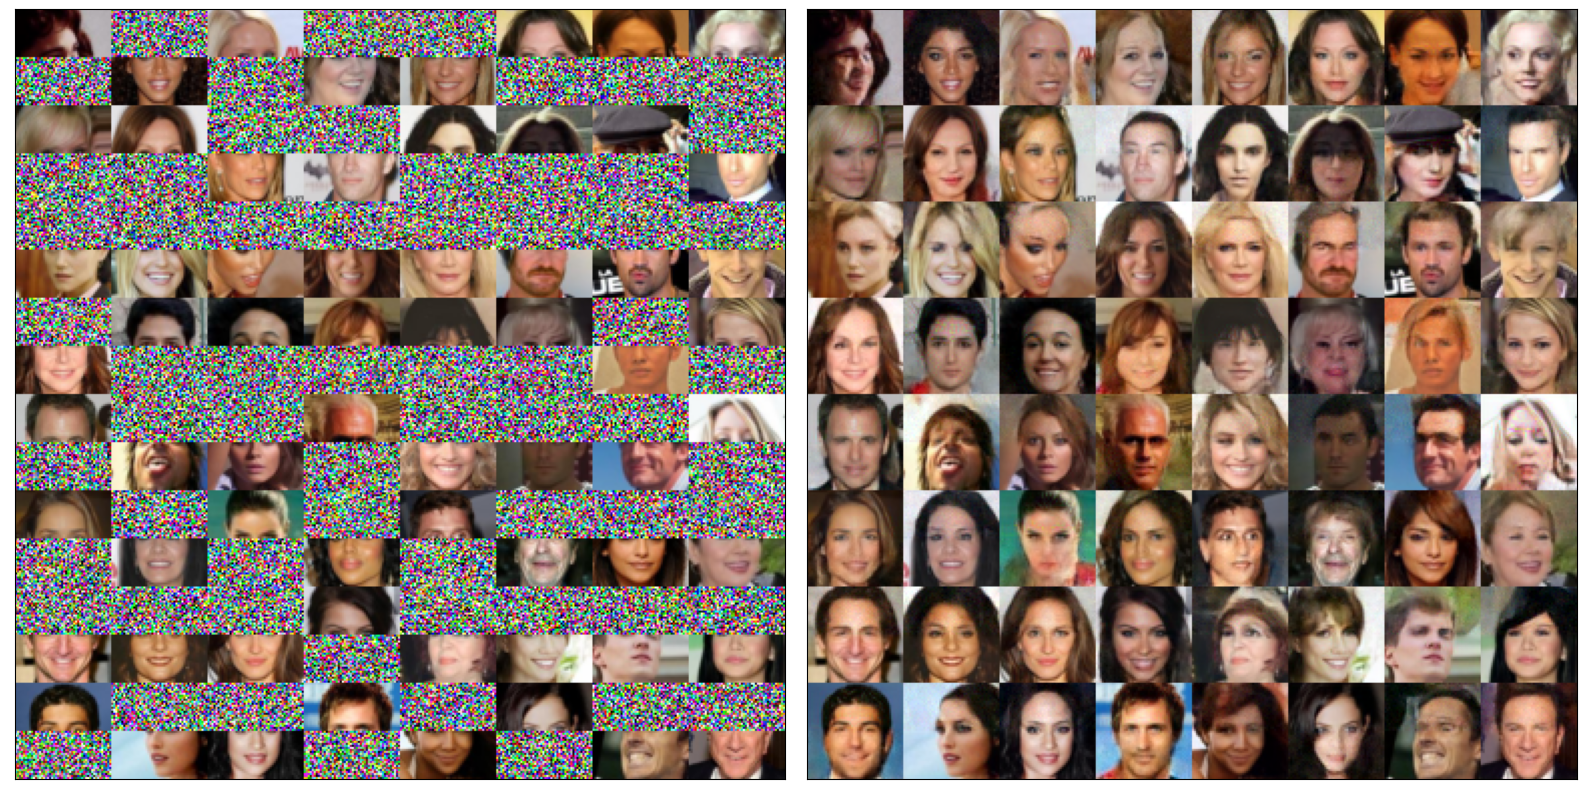

In [30]:
img = torch.vstack([img, img])

figsize(16,8)
plt.subplot(121)
noised_img = x_1.view(B, C + C_cond, H, W)[:,:C]
noised_img = torch.vstack([noised_img, noised_img])
noised_img = noised_img*torch.tensor(config.data.norm_std).view(1,config.data.num_channels,1,1).to(noised_img.device)
noised_img = noised_img + torch.tensor(config.data.norm_mean).view(1,config.data.num_channels,1,1).to(noised_img.device)
plt.xticks([])
plt.yticks([])
_ = plt.imshow(stack_imgs(noised_img), cmap='gray')
plt.subplot(122)
plt.xticks([])
plt.yticks([])
_ = plt.imshow(stack_imgs(img), cmap='gray')
plt.tight_layout()

## Visualize

In [73]:
@torch.no_grad()
def solve_ode(device, dxdt, x, i_inter=[], t0=1.0, t1=-1.0, dt=-1e-3):
    x_inter = []
    t_inter = []
    for i, t in enumerate(np.arange(t0, t1, dt)):
        if i in i_inter:
            x_inter.append(x.clone())
            t_inter.append(t)
        t_vec = (t*torch.ones([x.shape[0],1])).to(device)
        with torch.enable_grad():
            x.requires_grad = True
            x.data += dt * dxdt(t_vec,x).detach()
            x.requires_grad = False
    return x, x_inter, t_inter

frame_ids = list(range(500, 2000))[::10]
frame_ids.append(1999)
x_1, _ = q_t(x, t1*torch.ones([B, 1]).to(device))
x_0, x_inter, t_inter = solve_ode(device, loss.get_dxdt(), x_1.clone(), frame_ids)

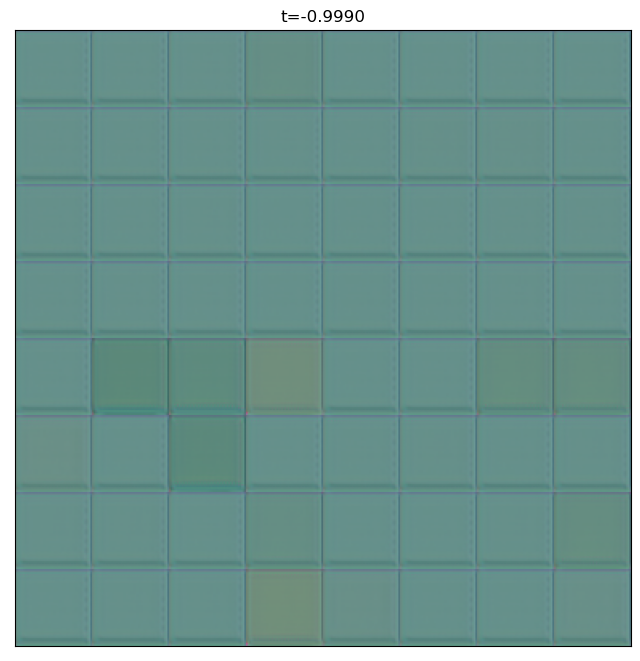

In [74]:
figsize(10,8)
# x_0 = torch.remainder(x_0, 1.0)
# x_0 = torch.clamp(x_0, 0.25, 0.75)
# x_0 = 2*(x_0 - 0.25)
x_0 = x_0.view(B, C, H, W)
x_0 = x_0*torch.tensor(config.data.norm_std).view(1,config.data.num_channels,1,1).to(noised_img.device)
x_0 = x_0 + torch.tensor(config.data.norm_mean).view(1,config.data.num_channels,1,1).to(noised_img.device)

big_img = stack_imgs(x_0)
plt.title(f't={t_inter[-1]:.4f}')
plt.xticks([])
plt.yticks([])
_ = plt.imshow(big_img, cmap='gray')

In [75]:
!rm -r ./gifs/am_celeba_diffusion

In [76]:
!mkdir ./gifs/am_celeba_diffusion

In [79]:
for i in range(len(x_inter)):
    x_t, t = x_inter[i], t_inter[i]
#     x_t = torch.remainder(x_t, 1.0)
#     x_t = torch.clamp(x_t, 0.25, 0.75)
#     x_t = 2*(x_t - 0.25)
    x_t = x_t.view(B, C, H, W)
    x_t = x_t*torch.tensor(config.data.norm_std).view(1,config.data.num_channels,1,1).to(noised_img.device)
    x_t = x_t + torch.tensor(config.data.norm_mean).view(1,config.data.num_channels,1,1).to(noised_img.device)
    big_img = stack_imgs(x_t.cpu())
    plt.imshow(big_img, cmap='gray')
    plt.title(f't={t:.4f}')
    plt.xticks([])
    plt.yticks([])
    plt.savefig('gifs/am_celeba_diffusion/%.3d.png' % i, bbox_inches='tight', dpi=60)
    plt.clf()

<Figure size 1000x800 with 0 Axes>

In [80]:
!convert -delay 10 -loop 0 ./gifs/am_celeba_diffusion/*.png ./gifs/am_celeba_diffusion.gif